In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
from torch.utils.data import TensorDataset, DataLoader
%matplotlib inline
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

grid = 30
batch = 32
degree = 4

def xy(lower=-5, upper=5):
    g = np.linspace(lower, upper, grid)
    X, Y = np.meshgrid(g, g)
    return X, Y

def test_data(batch=32, scale=10):
    # z = torch.tensor(np.sort(np.random.normal(loc=0, size=(batch, 1, 30, 30), scale=100)), dtype=torch.float32).to(DEVICE)
    # z += torch.tensor(np.sort(np.random.normal(loc=0, size=(batch, 1, 30, 30), scale=100), axis=2).copy(), dtype=torch.float32).to(DEVICE)
    z = []
    for i in range(batch):
        z.append([generate_perlin_noise_2d([30, 30], [1, 1])*scale])
    return torch.tensor(z, dtype=torch.float32).to(DEVICE)

def F(X, Y, C, degree=degree):
    z = 0
    for i in range(degree):
        C0 = torch.reshape(C[:, i], (X.size(dim=0), 1, 1))
        C1 = torch.reshape(C[:, i+degree], (X.size(dim=0), 1, 1))
        z += C0 * X**(i+1) + C1 * Y**(i+1)

    z += torch.reshape(C[:, degree*2], (X.size(dim=0), 1, 1))

    res = torch.reshape(z, (X.size(dim=0), 1, grid, grid))
    return res

# https://pvigier.github.io/2018/06/13/perlin-noise-numpy.html
def generate_perlin_noise_2d(shape, res):
    def f(t):
        return 6*t**5 - 15*t**4 + 10*t**3

    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0],0:res[1]:delta[1]].transpose(1, 2, 0) % 1
    # Gradients
    angles = 2*np.pi*np.random.rand(res[0]+1, res[1]+1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    g00 = gradients[0:-1,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g10 = gradients[1:,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g01 = gradients[0:-1,1:].repeat(d[0], 0).repeat(d[1], 1)
    g11 = gradients[1:,1:].repeat(d[0], 0).repeat(d[1], 1)
    # Ramps
    n00 = np.sum(grid * g00, 2)
    n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1])) * g10, 2)
    n01 = np.sum(np.dstack((grid[:,:,0], grid[:,:,1]-1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
    # Interpolation
    t = f(grid)
    n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
    n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
    return np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1)

In [11]:
X_, Y_ = xy()
X__ = torch.tensor(np.tile([X_],(batch,1,1)), dtype=torch.float32).to(DEVICE)
Y__ = torch.tensor(np.tile([Y_],(batch,1,1)), dtype=torch.float32).to(DEVICE)

print(X__.shape)

X = torch.tensor(X_, dtype=torch.float32).to(DEVICE)
Y = torch.tensor(Y_, dtype=torch.float32).to(DEVICE)

Z = []

for i in range(100):
    gt = torch.rand((batch, degree*2+1), dtype=torch.float32).to(DEVICE)
    # z = F(X__, Y__, gt)
    z = test_data()
    Z.append(z)

train_data = torch.cat(Z)

print(train_data.size())

gt = torch.rand((batch, degree*2+1), dtype=torch.float32).to(DEVICE)
# print(gt)

# z = F(X__, Y__, gt)
z = test_data()
# print(z)
# test_data = torch.reshape(z, (batch, 1, 30, 30))

train_dataset = TensorDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=False)
test_dataset = TensorDataset(z)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

torch.Size([32, 30, 30])
torch.Size([3200, 1, 30, 30])


In [12]:
import torch
import torch.nn as nn

class PointFitting(nn.Module):
    def __init__(self):
        super(PointFitting, self).__init__()
        layers = [
            torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2, 2)),
            torch.nn.Conv2d(in_channels=3, out_channels=2, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2, 2)),
            torch.nn.Flatten(),
            torch.nn.Linear(98, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, degree*2+1)
        ]
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
    
model = PointFitting()
model.to(DEVICE)
loss_fn = torch.nn.MSELoss(reduction='sum')

rate_learning = 1e-4
epochs = 300

optim = torch.optim.Adam(model.parameters(), lr=rate_learning)

for i in range(epochs):
    model.eval()
    loss_sum = 0
    for input in test_loader:
        input = input[0].to(DEVICE)
        y = model(input)
        loss = loss_fn(F(X__, Y__, y), input)
        loss_sum += loss.mean()
    print("epoch={0} loss_sum={1}".format(i, loss_sum))
    model.train()
    for input in train_loader:
        input = input[0].to(DEVICE)
        y = model(input)
        loss = loss_fn(F(X__, Y__, y), input)
        optim.zero_grad()
        loss.backward()
        optim.step()

epoch=0 loss_sum=9481259.0
epoch=1 loss_sum=254606.359375
epoch=2 loss_sum=219919.640625
epoch=3 loss_sum=205329.984375
epoch=4 loss_sum=196286.5625
epoch=5 loss_sum=189507.1875
epoch=6 loss_sum=183451.140625
epoch=7 loss_sum=178472.53125
epoch=8 loss_sum=174165.921875
epoch=9 loss_sum=170573.90625
epoch=10 loss_sum=167293.03125
epoch=11 loss_sum=164242.84375
epoch=12 loss_sum=161525.09375
epoch=13 loss_sum=159093.34375
epoch=14 loss_sum=156553.9375
epoch=15 loss_sum=153938.375
epoch=16 loss_sum=150954.109375
epoch=17 loss_sum=147934.84375
epoch=18 loss_sum=143796.15625
epoch=19 loss_sum=138640.03125
epoch=20 loss_sum=133443.671875
epoch=21 loss_sum=128469.4765625
epoch=22 loss_sum=123934.4453125
epoch=23 loss_sum=119675.1640625
epoch=24 loss_sum=115696.09375
epoch=25 loss_sum=112515.375
epoch=26 loss_sum=109914.5859375
epoch=27 loss_sum=107882.46875
epoch=28 loss_sum=105433.4375
epoch=29 loss_sum=102189.796875
epoch=30 loss_sum=99098.875
epoch=31 loss_sum=95964.890625
epoch=32 loss_su

tensor([[ 8.,  2., -3., 10., -5.,  3.,  2.]], device='cuda:0') tensor([[ 2.1757e-02,  1.8051e-01, -1.1562e-02, -3.0236e-03,  5.9943e-02,
          2.7205e-01,  3.5814e-03, -4.3631e-03, -6.8974e+00]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


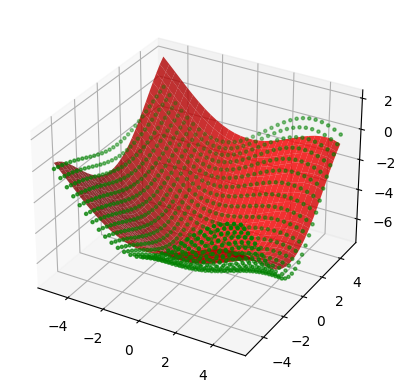

In [40]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

g_test = torch.tensor([[8.0, 2.0, -3.0, 10.0, -5.0, 3.0, 2.0]]).to(DEVICE)
X___ = torch.reshape(X, (1, 1, 30, 30))
Y___ = torch.reshape(Y, (1, 1, 30, 30))

# z = F(X___, Y___, g_test)
z = test_data(1)

output = model(z)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

print(g_test, output)

surf = ax.scatter(X___.cpu().detach().numpy()[0][0], Y___.cpu().detach().numpy()[0][0], z.cpu().detach().numpy()[0][0], color='g', s=5)
surf = ax.plot_surface(X___.cpu().detach().numpy()[0][0], Y___.cpu().detach().numpy()[0][0], F(X___, Y___, output).cpu().detach().numpy()[0][0], color='r', rstride=1, cstride=1, alpha=0.8)


plt.show()
